In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import decimal
from scipy.stats import trim_mean as tm
import statistics as stats

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"erixyz","key":"192e825403d461fd6dd4aab6be96f111"}'}

In [ ]:
#important stuff. always add
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#download the dataset
!kaggle datasets download -d fireballbyedimyrnmom/us-counties-covid-19-dataset

 47% 6.00M/12.7M [00:00<00:00, 61.8MB/s]
100% 12.7M/12.7M [00:00<00:00, 80.8MB/s]


In [ ]:
#import the datset
df = pd.read_csv("/content/us-counties-covid-19-dataset.zip")
df.tail(5)

,date,county,state,fips,cases,deaths
1219079,2021-04-13,Sweetwater,Wyoming,56037.0,4107,37.0
1219080,2021-04-13,Teton,Wyoming,56039.0,3675,9.0
1219081,2021-04-13,Uinta,Wyoming,56041.0,2153,12.0
1219082,2021-04-13,Washakie,Wyoming,56043.0,897,26.0
1219083,2021-04-13,Weston,Wyoming,56045.0,642,5.0


In [ ]:
df[df['county'] == 'Los Angeles'][44:56]

,date,county,state,fips,cases,deaths
1002,2020-03-10,Los Angeles,California,6037.0,20,0.0
1168,2020-03-11,Los Angeles,California,6037.0,28,1.0
1374,2020-03-12,Los Angeles,California,6037.0,32,1.0
1634,2020-03-13,Los Angeles,California,6037.0,40,1.0
1951,2020-03-14,Los Angeles,California,6037.0,53,1.0
2330,2020-03-15,Los Angeles,California,6037.0,69,1.0
2764,2020-03-16,Los Angeles,California,6037.0,94,1.0
3245,2020-03-17,Los Angeles,California,6037.0,144,1.0
3798,2020-03-18,Los Angeles,California,6037.0,190,1.0
4458,2020-03-19,Los Angeles,California,6037.0,231,2.0


adjust the date index to datetime64[ns].

In [ ]:
def countyIso(countyName, stateName):
  #function that cleans up desired subsets of dataframe. returns time series of county with cases and corresponding cases and deaths.
  county = df[(df['county'] == countyName) & (df['state'] == stateName)]
  #county = county.reset_index().drop(columns=["index", "fips"])
  county = county.reset_index().drop(columns=["index"])
  county = county.set_index('date')
  county.index = pd.to_datetime(county.index)
  return county

next goal: input the richest and poorest counties from wikipedia (10 each)

richest: https://en.wikipedia.org/wiki/List_of_highest-income_counties_in_the_United_States \
poorest: https://en.wikipedia.org/wiki/List_of_lowest-income_counties_in_the_United_States \
highest pop. cities with the most homeless: https://www.statista.com/statistics/205648/percentage-of-poor-families-in-the-top-20-most-populated-cities-in-the-us/ \
counties ranked by per capita income: https://en.wikipedia.org/wiki/List_of_United_States_counties_by_per_capita_income \

In [ ]:
def diseaseDays(county):
  #this creates a datetime array using the counties index
  startDate = county.index[0]
  size = len(county)
  days = pd.date_range(startDate, periods = size)
  return days

In [ ]:
def doublingtimefunc(county, startdate, enddate, doubtype):
  #A simple function to calculate the amount of time it takes for values in dataframe to double.
  days= pd.date_range(startdate,enddate)
  icases = county.loc[startdate, doubtype]
  daycounter = -1

  for i,d in enumerate(days):
    if county.loc[d, doubtype] < 2*icases:
      daycounter += 1
      if d == enddate:
          daycounter = 0
          break;
    else:
      daycounter +=1
      break;
  
  return daycounter

In [ ]:
def expGrowth(dtime):
  #take in doubling time and returns exponential growth rate.
  return np.log(2)/dtime

def expGrowthRate(county, doubtype):
  #calculates the exponential rate of growth for a COUNTY and returns an array
  doubtime = []
  setofdays = diseaseDays(county)
  for time in setofdays:
    doubtime.append(doublingtimefunc(county, time, setofdays[-1], doubtype))

  return np.array(expGrowth(doubtime))


def expGrowthRatePlot(r, county):
  #plots the exponential rate of growth for a county.
  setofdays = diseaseDays(county)
  plt.plot(setofdays, r)


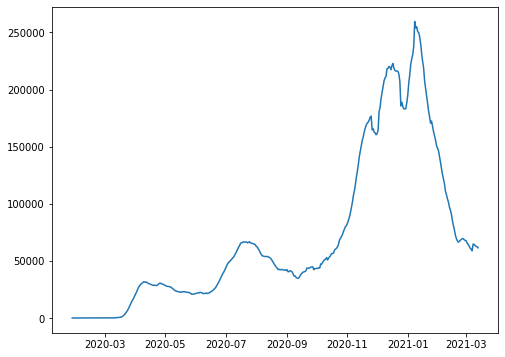

In [ ]:
usa = df.groupby('date').sum().drop(columns = 'fips')
usa_cases, usa_dates = usa.cases, pd.to_datetime(usa.index)
plt.figure(figsize = (8,6))
plt.plot(usa_dates, usa_cases.diff().rolling(window=7).mean())

Notice that the pandemic begins to really lose steam once summer is in motion. In this case, I should edit the dataframes in question to stop at the beginning of summer. Saturday June 20th.

In [ ]:
def sampling(data):
  def selection(data):
    #this part randomly selects from the dataframe
    val = random.randrange(start = 0, stop = len(data), step = 1)
    countyname, statename = data.iloc[val].county, data.iloc[val].state
    county_df = countyIso(countyname, statename)
    return county_df
  
  #this part ensures the dataframe is not empty
  selectionOut = selection(data)
  while len(selectionOut) == 0:
    selectionOut = selection(data)
  return selectionOut

def countyStringClean(data):
  #this gets rid of unnecessary strings in the data set including " City" or " County"
  strings = data.county.tolist()
  badwords = [' City', ' County', ' Census Area']

  correct = []
  idx = []

  for bad in badwords:
    for index, name in enumerate(strings):
      if bad in name:
        correct.append(name.replace(bad, ''))
        idx.append(index)

  for idx_idx, idx_val in enumerate(idx):
    strings[idx_val] = correct[idx_idx]
  
  data.county = strings
  return data

In [ ]:
#import and clean datasets required for sampling
#note: there is a unicode error when utilizing original dataset. removed all islands/territories.
plus90 = countyStringClean(pd.read_csv('/content/90plus.csv'))
plus80 = countyStringClean(pd.read_csv('/content/80plus.csv'))
plus70 = countyStringClean(pd.read_csv('/content/70plus.csv'))
plus60 = countyStringClean(pd.read_csv('/content/60plus.csv'))
plus50 = countyStringClean(pd.read_csv('/content/50plus.csv'))
plus40 = countyStringClean(pd.read_csv('/content/40plus.csv'))
plus30 = countyStringClean(pd.read_csv('/content/30plus.csv'))
plus20 = countyStringClean(pd.read_csv('/content/20plus.csv'))
plus10 = countyStringClean(pd.read_csv('/content/10plus.csv'))
plus0 = countyStringClean(pd.read_csv('/content/0plus.csv'))

In [ ]:
#run the code 10 times to generate random counties. if a county repeats, rerun the code.
#ampling(plus90)
#sampling(plus80)
#sampling(plus70)
#sampling(plus60)

randomly selected counties:\
90-100 percentile: 
*   Miner, South Dakota
*   Middlesex, Virginia
*   Washington, Rhode Island
*   Kent, Maryland
*   Camden, New Jersey
*   Douglas, Colorado
*   Snohomish, Washington
*   Fairfax, Virginia
*   Fairfield, Connecticut
*   Ozaukee, Wisconsin
*   Ulster, New York
*   San Mateo, California

80-90 percentile:
*   Carteret, North Carolina
*   Emmet, Iowa
*   Chisago, Minnesota
*   Johnson, Wyoming
*   McHenry, North Dakota
*   Bedford, Virginia
*   Northampton, Pennsylvania
*   Greene, Ohio
*   Kanawha, West Virginia
*   Sarpy, Nebraska
*   Warrick, Indiana
*   East Baton Rouge, Louisiana

70-80 percentile:
*   Franklin, Nebraska
*   Dawson, Montana
*   Polk, Minnesota
*   Skagit, Washington
*   Lackawanna, Pennsylvania
*   York, South Carolina
*   Fremont, Iowa
*   Chelan, Washington
*   Hardin, Texas
*   Lorain, Ohio
*   Stearns, Minnesota
*   Grand Forks, North Dakota

60- 70 percentile:
*   Hood River, Oregon
*   Kane, Utah
*   Mower, Minnesota
*   Kootenai, Idaho
*   Winnebago, Iowa
*   Dodge, Wisonsin
*   Kimball, Nebraska
*   Stark, Ohio
*   White, Illinois
*   Asotin, Washington
*   Cooke, Texas
*   Churchill, Nevada




In [ ]:
#sampling(plus50)
#sampling(plus40)
#sampling(plus30)

50-60 percentile:
*   Jackson, Oklahoma
*   Pamlico, North Carolina
*   Weber, Utah
*   Humboldt, California
*   Washita, Oklahoma
*   Escambia, Florida
*   Brookings, South Dakota
*   Pickaway, Ohio
*   Lee, Alabama
*   Jefferson, Texas
*   Bosque, Texas
*   Page, Iowa

40-50 percentile:
*   Allen, Ohio
*   Henry, Tennessee
*   Franklin, Tennessee
*   Cumberland, New Jersey
*   Buchanan, Missouri
*   Noble, Indiana
*   Coles, Illinois
*   Morrow, Ohio
*   Pontotoc, Oklahoma
*   Trumbull, Ohio
*   Union, Pennsylvania
*   Lyon, Nevada

30-40 percentile:
*   Hernando, Florida
*   Graves, Kentucky
*   Jefferson, Indiana
*   Fayette, Pennsylvania
*   Avery, North Carolina
*   Finney, Kansas
*   Delaware, Oklahoma
*   Jefferson, Tennessee
*   Ashe, North Carolina
*   Allen, Kansas
*   San Bernardino, California
*   Tangipahoa, Louisiana


In [ ]:
#sampling(plus20)
#sampling(plus10)
#sampling(plus0)

20-30 percentile:
*   Russell, Alabama
*   Polk, Tennessee
*   Acadia, Louisiana
*   Cherokee, Kansas
*   Branch, Michigan
*   Franklin, Illinois
*   Gonzales, Texas
*   Hardin, Ohio
*   Johnson, Kentucky
*   Simpson, Kentucky
*   St. Landry, Louisiana	
*   Floyd, Georgia

10-20 percentile:
*   Franklin, Alabama
*   Yuma, Arizona
*   Gulf, Florida
*   Wilkes, North Carolina
*   Fremont, Colorado
*   Carter, Tennessee
*   Lamb, Texas
*   Seward, Kansas
*   Taylor, Kentucky
*   Caldwell, North Carolina
*   Yalobusha,	Mississippi
*   Columbus, North Carolina

0-10 percentile:
*   Liberty, Florida
*   Wheeler, Georgia
*   Amite, Mississippi
*   Hendry, Florida
*   Athens, Ohio
*   Washington, Florida
*   Johnson, Georgia
*   Lee, Kentucky
*   Hamilton, Florida
*   Holmes Mississippi
*   Lake, Michigan
*   Campbell, Tennessee








In [ ]:
#90-100 percentile:
county90_0,county90_1,county90_2,county90_3 = countyIso('Miner', 'South Dakota'), countyIso('Middlesex', 'Virginia'), countyIso('Washington', 'Rhode Island'), countyIso('Kent', 'Maryland')
county90_4,county90_5,county90_6,county90_7 = countyIso('Camden', 'New Jersey'), countyIso('Douglas', 'Colorado'), countyIso('Snohomish', 'Washington'), countyIso('Fairfax', 'Virginia')
county90_8,county90_9,county90_10,county90_11 = countyIso('Fairfield', 'Connecticut'), countyIso('Ozaukee', 'Wisconsin'), countyIso('Ulster', 'New York'), countyIso('San Mateo', 'California')

county90s = [county90_0,county90_1,county90_2,county90_3,county90_4,county90_5,county90_6,county90_7,county90_8,county90_9,county90_10,county90_11]

In [ ]:
#80-90 percentile:
county80_0,county80_1,county80_2,county80_3 = countyIso('Carteret', 'North Carolina'), countyIso('Emmet', 'Iowa'), countyIso('Chisago', 'Minnesota'), countyIso('Johnson', 'Wyoming')
county80_4,county80_5,county80_6,county80_7 = countyIso('McHenry', 'North Dakota'), countyIso('Bedford', 'Virginia'), countyIso('Northampton', 'Pennsylvania'), countyIso('Greene', 'Ohio')
county80_8,county80_9,county80_10,county80_11 = countyIso('Kanawha', 'West Virginia'), countyIso('Sarpy', 'Nebraska'), countyIso('Warrick', 'Indiana'), countyIso('East Baton Rouge', 'Louisiana')

county80s = [county80_0,county80_1,county80_2,county80_3,county80_4,county80_5,county80_6,county80_7,county80_8,county80_9,county80_10,county80_11]

In [ ]:
#70-80 percentile:
county70s = [countyIso('Franklin', 'Nebraska'), countyIso('Dawson', 'Montana'), countyIso('Polk', 'Minnesota'), countyIso('Skagit', 'Washington'),
             countyIso('Lackawanna', 'Pennsylvania'), countyIso('York', 'South Carolina'), countyIso('Fremont', 'Iowa'),
             countyIso('Chelan', 'Washington'), countyIso('Hardin', 'Texas'), countyIso('Lorain', 'Ohio'),
             countyIso('Stearns', 'Minnesota'), countyIso('Grand Forks', 'North Dakota')]

In [ ]:
#60-70 percentile:
county60s = [countyIso('Hood River', 'Oregon'), countyIso('Kane', 'Utah'), countyIso('Mower', 'Minnesota'), countyIso('Kootenai', 'Idaho'),
             countyIso('Winnebago', 'Iowa'), countyIso('Dodge', 'Wisconsin'), countyIso('Kimball', 'Nebraska'),
             countyIso('Stark', 'Ohio'), countyIso('White', 'Illinois'), countyIso('Asotin', 'Washington'),
             countyIso('Cooke', 'Texas'), countyIso('Churchill', 'Nevada')]

In [ ]:
#50-60 percentile:
county50s = [countyIso('Jackson', 'Oklahoma'), countyIso('Pamlico', 'North Carolina'), countyIso('Weber', 'Utah'), countyIso('Humboldt', 'California'),
             countyIso('Washita', 'Oklahoma'), countyIso('Escambia', 'Florida'), countyIso('Brookings', 'South Dakota'),
             countyIso('Pickaway', 'Ohio'), countyIso('Lee', 'Alabama'), countyIso('Jefferson', 'Texas'),
             countyIso('Bosque', 'Texas'), countyIso('Page', 'Iowa')]

In [ ]:
#40-50 percentile:
county40s = [countyIso('Allen', 'Ohio'), countyIso('Henry', 'Tennessee'), countyIso('Franklin', 'Tennessee'), countyIso('Cumberland', 'New Jersey'),
             countyIso('Buchanan', 'Missouri'), countyIso('Noble', 'Indiana'), countyIso('Coles', 'Illinois'),
             countyIso('Morrow', 'Ohio'), countyIso('Pontotoc', 'Oklahoma'), countyIso('Trumbull', 'Ohio'),
             countyIso('Union', 'Pennsylvania'), countyIso('Lyon', 'Nevada')]

In [ ]:
#30-40 percentile:
county30s = [countyIso('Hernando', 'Florida'), countyIso('Graves', 'Kentucky'), countyIso('Jefferson', 'Indiana'), countyIso('Fayette', 'Pennsylvania'),
             countyIso('Avery', 'North Carolina'), countyIso('Finney', 'Kansas'), countyIso('Delaware', 'Oklahoma'),
             countyIso('Jefferson', 'Tennessee'), countyIso('Ashe', 'North Carolina'), countyIso('Allen', 'Kansas'),
             countyIso('San Bernardino', 'California'), countyIso('Tangipahoa', 'Louisiana')]

In [ ]:
#20-30 percentile:
county20s = [countyIso('Russell', 'Alabama'), countyIso('Polk', 'Tennessee'), countyIso('Acadia', 'Louisiana'), countyIso('Cherokee', 'Kansas'),
             countyIso('Branch', 'Michigan'), countyIso('Franklin', 'Illinois'), countyIso('Gonzales', 'Texas'),
             countyIso('Hardin', 'Ohio'), countyIso('Johnson', 'Kentucky'), countyIso('Simpson', 'Kentucky'),
             countyIso('St. Landry', 'Louisiana'), countyIso('Floyd', 'Georgia')]

In [ ]:
#10-20 percentile:
county10s = [countyIso('Franklin', 'Alabama'), countyIso('Yuma', 'Arizona'), countyIso('Gulf', 'Florida'), countyIso('Wilkes', 'North Carolina'),
             countyIso('Fremont', 'Colorado'), countyIso('Carter', 'Tennessee'), countyIso('Lamb', 'Texas'),
             countyIso('Seward', 'Kansas'), countyIso('Taylor', 'Kentucky'), countyIso('Caldwell', 'North Carolina'),
             countyIso('Yalobusha', 'Mississippi'), countyIso('Columbus', 'North Carolina')]

In [ ]:
#0-10 percentile:
county0s = [countyIso('Liberty', 'Florida'), countyIso('Wheeler', 'Georgia'), countyIso('Amite', 'Mississippi'), countyIso('Hendry', 'Florida'),
             countyIso('Athens', 'Ohio'), countyIso('Washington', 'Florida'), countyIso('Johnson', 'Georgia'),
             countyIso('Lee', 'Kentucky'), countyIso('Hamilton', 'Florida'), countyIso('Holmes', 'Mississippi'),
             countyIso('Lake', 'Michigan'), countyIso('Campbell', 'Tennessee')]

In [ ]:
#initialize lists for rates
r90, r80, r70, r60, r50, r40, r30, r20, r10, r0 = [], [], [], [], [], [], [], [], [], []

In [ ]:
def forLoopforExpGrowth(countyArray):
  #calculates the r for each county in the array
  throwaway = []
  for i in countyArray:
    throwaway.append(expGrowthRate(i,'cases')[:77])
  return throwaway

In [ ]:
#apply function to calculate r for each county in each array
r90 = forLoopforExpGrowth(county90s)
r80 = forLoopforExpGrowth(county80s)
r70 = forLoopforExpGrowth(county70s)
r60 = forLoopforExpGrowth(county60s)
r50 = forLoopforExpGrowth(county50s)
r40 = forLoopforExpGrowth(county40s)
r30 = forLoopforExpGrowth(county30s)
r20 = forLoopforExpGrowth(county20s)
r10 = forLoopforExpGrowth(county10s)
r0 = forLoopforExpGrowth(county0s)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#list comprehension to calculate the trimmed mean of r for each county
tm90 = [tm(i,0.025) for i in r90]
tm80 = [tm(i,0.025) for i in r80]
tm70 = [tm(i,0.025) for i in r70]
tm60 = [tm(i,0.025) for i in r60]
tm50 = [tm(i,0.025) for i in r50]
tm40 = [tm(i,0.025) for i in r40]
tm30 = [tm(i,0.025) for i in r30]
tm20 = [tm(i,0.025) for i in r20]
tm10 = [tm(i,0.025) for i in r10]
tm0 = [tm(i,0.025) for i in r0]

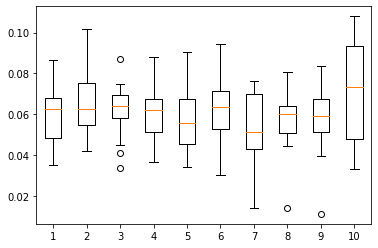

In [ ]:
data1 = [tm0, tm10, tm20, tm30, tm40, tm50, tm60, tm70, tm80, tm90]
plt.boxplot(data1);

In [ ]:
med90 = [stats.median(i) for i in r90]
med80 = [stats.median(i) for i in r80]
med70 = [stats.median(i) for i in r70]
med60 = [stats.median(i) for i in r60]
med50 = [stats.median(i) for i in r50]
med40 = [stats.median(i) for i in r40]
med30 = [stats.median(i) for i in r30]
med20 = [stats.median(i) for i in r20]
med10 = [stats.median(i) for i in r10]
med0 = [stats.median(i) for i in r0]

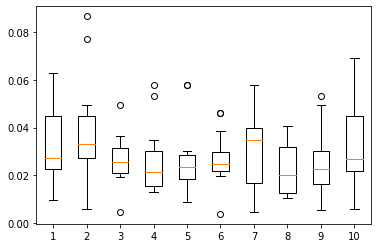

In [ ]:
data2 = [med0,med10,med20,med30,med40,med50,med60,med70,med80,med90]
plt.boxplot(data2);

In [ ]:
mean90 = [stats.mean(i) for i in r90]
mean80 = [stats.mean(i) for i in r80]
mean70 = [stats.mean(i) for i in r70]
mean60 = [stats.mean(i) for i in r60]
mean50 = [stats.mean(i) for i in r50]
mean40 = [stats.mean(i) for i in r40]
mean30 = [stats.mean(i) for i in r30]
mean20 = [stats.mean(i) for i in r20]
mean10 = [stats.mean(i) for i in r10]
mean0 = [stats.mean(i) for i in r0]

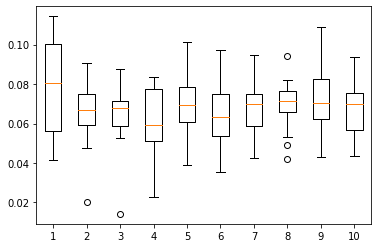

In [ ]:
data3 = [mean90,mean80,mean70,mean60,mean50,mean40,mean30,mean20,mean10,mean0]
plt.boxplot(data3);

Per capita income does not appear to play a significant role in the initial spread of COVID-19 based on the above boxplots.

The next goal is to impute doubling time's (r) into the wikipedia dataset. Regress on this newly constructed dataframe.

In [ ]:
#small scale. will attempt to create a dataframe with only two counties:
#Fairfax, Virginia
#San Mateo, California

fairfax = countyIso('Fairfax', 'Virginia')
san_mateo = countyIso('San Mateo', 'California')

r_f = tm(expGrowthRate(fairfax, 'cases')[:77], 0.025)
r_s = tm(expGrowthRate(san_mateo, 'cases')[:77], 0.025) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#one method to combine the dataset. i stupidly dropped some essential columns.
#as a result of my blunder, i will try to use the wikipedia extension.

#import os
#import glob
#import pandas as pd
#os.chdir("/content")

#extension = 'csv'
#all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
#combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
#combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

In [ ]:
#webscraping using BeautifulSoup
from bs4 import BeautifulSoup
import requests

wiki_url = 'https://en.wikipedia.org/wiki/List_of_United_States_counties_by_per_capita_income'
table_name = 'wikitable sortable' 
response = requests.get(wiki_url)
soup = BeautifulSoup(response.text, 'html.parser')
soup_table = soup.find('table', {'class':table_name})
wiki_table = pd.read_html(str(soup_table))[0]

In [ ]:
#cleaning process for the entire dataframe

#change col names to something easier to handle
wiki_table.columns = ['pos', 'county', 'state', 'pc_income', 'medhouse_inc',
                      'medfam_inc', 'pop', 'households']

#drop unnecessary 'counties'
wiki_table = wiki_table[wiki_table["state"].str.contains("Puerto Rico") == False]
wiki_table = wiki_table[wiki_table["state"].str.contains("American Samoa") == False]
wiki_table = wiki_table[wiki_table["state"].str.contains("Guam") == False]
wiki_table = wiki_table[wiki_table["state"].str.contains("U.S. Virgin Islands") == False]
wiki_table = wiki_table[wiki_table["state"].str.contains("Northern Mariana Islands") == False]
wiki_table = wiki_table.dropna()

#change data from object to floats
wiki_table['pc_income'] = wiki_table['pc_income'].str.replace(',', '')
wiki_table['pc_income'] = wiki_table['pc_income'].str.replace('$', '')
wiki_table['pc_income'] = wiki_table['pc_income'].astype(float)

wiki_table['medhouse_inc'] = wiki_table['medhouse_inc'].str.replace(',', '')
wiki_table['medhouse_inc'] = wiki_table['medhouse_inc'].str.replace('$', '')
wiki_table['medhouse_inc'] = wiki_table['medhouse_inc'].astype(float)

wiki_table['medfam_inc'] = wiki_table['medfam_inc'].str.replace(',', '')
wiki_table['medfam_inc'] = wiki_table['medfam_inc'].str.replace('$', '')
wiki_table['medfam_inc'] = wiki_table['medfam_inc'].astype(float)

#clean strings in county column to be more in line with what is found in NY Times dataframe
wiki_table = countyStringClean(wiki_table)

In [ ]:
#final cleaned dataset pulled from wikipedia:
print(wiki_table.shape)
wiki_table.head(3)

(3143, 8)


,pos,county,state,pc_income,medhouse_inc,medfam_inc,pop,households
0,1,New York,New York,62498.0,69659.0,84627.0,1605272.0,736192.0
1,2,Arlington,Virginia,62018.0,103208.0,139244.0,214861.0,94454.0
2,3,Falls Church,Virginia,59088.0,120000.0,152857.0,12731.0,5020.0


In [ ]:
#need to clean the NY Times dataset. observing only areas within the US, not terretories
df = df[df["state"].str.contains("Puerto Rico") == False]
df = df[df["state"].str.contains("Virgin Islands") == False]
df = df[df["state"].str.contains("Guam") == False]
df = df[df["state"].str.contains("Northern Mariana Islands") == False]
df = df[df["county"].str.contains("Unknown") == False]
df = df.drop(columns = 'fips')

In [ ]:
#create a copy of the cleaned wikipedia df
ols_tab = wiki_table.copy(deep=True)

#create new column in the wiki df for ols
ols_tab['exp_rate'] = [0] * len(ols_tab)

In [ ]:
#this is the format I will use to calculate r for each county and impute it into ols_tab
df[df['state'] == list(df.state.unique())[0]].county.unique()

array(['Snohomish', 'Spokane', 'King', 'Walla Walla', 'Chelan', 'Clark',
       'Jefferson', 'Pierce', 'Kittitas', 'Kitsap', 'Skagit', 'Whatcom',
       'Island', 'Thurston', 'Columbia', 'Grays Harbor', 'Yakima',
       'Grant', 'Klickitat', 'Lewis', 'Lincoln', 'Franklin', 'Mason',
       'Benton', 'Clallam', 'Cowlitz', 'San Juan', 'Stevens', 'Whitman',
       'Adams', 'Douglas', 'Ferry', 'Okanogan', 'Skamania',
       'Pend Oreille', 'Asotin', 'Wahkiakum', 'Pacific', 'Garfield'],
      dtype=object)

In [ ]:
#this takes forever...
states = list(df.state.unique())
for i in states:
  for j in df[df['state'] == i].county.unique():
    temp_county = countyIso(j,i)
    try:
      temp_r = tm(expGrowthRate(temp_county, 'cases')[:77], 0.025)
    except KeyError:
      continue
    else:
          idx = ols_tab[(ols_tab['state'] == i) & (ols_tab['county'] == j)]
          if idx.shape != (0,9):
            idx = int(idx.index[0])
            ols_tab.loc[idx, 'exp_rate'] = temp_r
          else:
            continue

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#about 3% of the dataset is unusable because it's either zeros or inf
#that's fine
ols_tab.exp_rate.value_counts()[0]/len(ols_tab)

0.028316894686605153

In [ ]:
#keep the original as back up just in case something goes wrong.
ols_tab1 = ols_tab.copy(deep=True)

In [ ]:
#drop the zeros and infs from the dataframe
indexforzeros = ols_tab1[ols_tab1['exp_rate'] == 0].index
ols_tab1.drop(indexforzeros, inplace=True)
indexforinfs = ols_tab1[ols_tab1['exp_rate'] == np.inf].index
ols_tab1.drop(indexforinfs, inplace=True)

In [ ]:
ols_tab1.head(5)

,pos,county,state,pc_income,medhouse_inc,medfam_inc,pop,households,exp_rate
1,2,Arlington,Virginia,62018.0,103208.0,139244.0,214861.0,94454.0,0.067843
3,4,Marin,California,56791.0,90839.0,117357.0,254643.0,102912.0,0.087517
5,6,Pitkin,Colorado,51814.0,72745.0,93981.0,17173.0,7507.0,0.022957
6,7,Los Alamos,New Mexico,51044.0,106686.0,124979.0,17979.0,7590.0,0.032179
7,8,Fairfax,Virginia,50532.0,110292.0,128596.0,1101071.0,389908.0,0.100812


In [ ]:
#download the dataset to utilize in R for regressions and stuff.
ols_tab1.to_csv(r'/content/olsdf.csv', index = False)

https://www.businessinsider.com/regions-of-united-states-2018-5#the-us-census-bureau-divides-the-united-states-into-four-regions-theres-the-northeast--1

In [ ]:
#categorize states by location...
#there are four regions according to the US Census Bureau
northeast_states = ['Maine', 'New Hampshire', 'Vermont',
             'Massachusetts', 'Rhode Island', 'Connecticut',
             'New York', 'New Jersey', 'Pennsylvania']

midwest_states = ['Ohio', 'Michigan', 'Indiana',
                  'Wisconsin', 'Illinois', 'Minnesota',
                  'Iowa', 'Missouri', 'North Dakota', 'South Dakota',
                  'Nebraska', 'Kansas']

west_states = ['Montana', 'Idaho', 'Wyoming',
               'Colorado', 'New Mexico', 'Arizona',
               'Utah', 'Nevada', 'California',
               'Oregon', 'Washington', 'Alaska',
               'Hawaii']

south_states = ['Delaware', 'Maryland', 'Virginia',
                'West Virginia', 'Kentucky', 'North Carolina',
                'South Carolina', 'Tennessee', 'Georgia', 'Florida',
                'Alabama', 'Mississippi', 'Arkansas', 'Louisiana',
                'Texas', 'Oklahoma']

#dummy cols per region
ols_tab1['NE_dum'] = [0] * len(ols_tab1)
ols_tab1['MW_dum'] = [0] * len(ols_tab1)
ols_tab1['W_dum'] = [0] * len(ols_tab1)
ols_tab1['S_dum'] = [0] * len(ols_tab1)

#reset index vals for tab
ols_tab1.pos = range(len(ols_tab1))
ols_tab1.index = ols_tab1.pos
ols_tab1.index

In [ ]:
#creation of dummies per region
for i,v in enumerate(ols_tab1.state):
  if v in northeast_states:
    ols_tab1.loc[i, 'NE_dum'] = 1
    ols_tab1.loc[i, 'MW_dum'] = 0
    ols_tab1.loc[i, 'W_dum'] = 0
  elif v in midwest_states:
    ols_tab1.loc[i, 'MW_dum'] = 1
    ols_tab1.loc[i, 'NE_dum'] = 0
    ols_tab1.loc[i, 'W_dum'] = 0
  elif v in west_states:
    ols_tab1.loc[i, 'W_dum'] = 1
    ols_tab1.loc[i, 'NE_dum'] = 0
    ols_tab1.loc[i, 'MW_dum'] = 0
  elif v in south_states:
    ols_tab1.loc[i, 'S_dum'] = 1
    ols_tab1.loc[i, 'NE_dum'] = 0
    ols_tab1.loc[i, 'MW_dum'] = 0
    ols_tab1.loc[i, 'W_dum'] = 0

In [ ]:
#download of df with dummies
ols_tab1.to_csv(r'/content/olsdf_wdum.csv', index = False)

In [ ]:
!pip install git+git://github.com/geopandas/geopandas.git &> /dev/null #the stuff after the & suppresses the code before it.

#need to clean up this dataset
import geopandas as gpd
geo = gpd.read_file('https://opendata.arcgis.com/datasets/ace8fa8bea514d07a3139e4657b3cd9c_0.geojson')
geo[:3]

,OBJECTID,GEO_ID,GEO_NAME,GEO_PARENT_NAME,FIPS_CODE,B02001_002E,B02001_002M,B02001_003E,B02001_003M,B02001_004E,B02001_004M,B02001_005E,B02001_005M,B02001_006E,B02001_006M,B02001_007E,B02001_007M,B02001_008E,B02001_008M,B03001_002E,B03001_002M,B03001_003E,B03001_003M,geometry
0,1,0500000US01001,Autauga County,Alabama,01001,42437,337,10565,230,159,68,568,166,32,36,409,348,1030,250,53672,NaN,1528,NaN,"POLYGON ((-86.41312 32.70739, -86.41305 32.690..."
1,2,0500000US01003,Baldwin County,Alabama,01003,179526,747,19764,377,1522,337,1680,360,9,13,2034,783,3572,671,198754,NaN,9353,NaN,"POLYGON ((-87.76516 31.29735, -87.76361 31.297..."
2,3,0500000US01005,Barbour County,Alabama,01005,12216,179,12266,196,72,43,96,40,1,3,778,192,353,161,24676,NaN,1106,NaN,"POLYGON ((-85.05603 32.06306, -85.05593 32.063..."


In [ ]:
geo.shape

(3220, 24)